In [ ]:
!pip -q install -U ultralytics==8.* pyyaml matplotlib pandas==2.2.2

import os
import random
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from IPython.display import display


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 145.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
SEED = 42
random.seed(SEED)

CONF_TH = 0.10
IMG_SIZE = 640
BASE_MODEL_WEIGHTS = "yolov8m.pt"

EPOCHS = 30
BATCH = 16  # אם OOM אז 8


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
ROOT = Path("/content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project")
ROBO_DIR = ROOT / "stage_2" / "split"

DATA_YAML_ORIG = ROBO_DIR / "data.yaml"
assert DATA_YAML_ORIG.exists(), f"Missing data.yaml: {DATA_YAML_ORIG}"

# Validate expected dataset folder structure
for split in ["train", "valid", "test"]:
    assert (ROBO_DIR / split / "images").exists(), f"Missing {split}/images"
    assert (ROBO_DIR / split / "labels").exists(), f"Missing {split}/labels"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def list_images_labels(split: str):
    img_dir = ROBO_DIR / split / "images"
    lbl_dir = ROBO_DIR / split / "labels"
    imgs = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
    lbls = sorted([p for p in lbl_dir.iterdir() if p.suffix.lower() == ".txt"])
    return imgs, lbls, img_dir, lbl_dir

def yolo_line_is_bbox(line: str) -> bool:
    # Expected YOLO bbox format: class x_center y_center width height (normalized 0..1)
    parts = line.strip().split()
    if len(parts) != 5:
        return False
    try:
        _ = int(float(parts[0]))  # class id
        vals = [float(x) for x in parts[1:]]
        return all(0.0 <= v <= 1.0 for v in vals)
    except:
        return False

report = {}
all_split_stems = {}

for split in ["train", "valid", "test"]:
    imgs, lbls, img_dir, lbl_dir = list_images_labels(split)

    stems_img = {p.stem for p in imgs}
    stems_lbl = {p.stem for p in lbls}

    # Detect missing/extra label files by filename stem
    missing_labels = sorted(list(stems_img - stems_lbl))
    extra_labels = sorted(list(stems_lbl - stems_img))

    empty_lbl = 0
    nonempty_lbl = 0
    bad_format = 0

    # Light label-content sanity check (sample up to 300 matched files)
    for stem in list(stems_img.intersection(stems_lbl))[:300]:
        txt = (lbl_dir / f"{stem}.txt").read_text().strip()
        if txt == "":
            empty_lbl += 1
            continue

        nonempty_lbl += 1
        # Flag files that contain any line not matching YOLO bbox format
        for ln in txt.splitlines():
            if not yolo_line_is_bbox(ln):
                bad_format += 1
                break

    report[split] = {
        "images": len(imgs),
        "labels": len(lbls),
        "missing_labels": len(missing_labels),
        "extra_labels": len(extra_labels),
        "empty_labels": empty_lbl,
        "nonempty_labels": nonempty_lbl,
        "bad_format_files_sampled": bad_format,
    }
    all_split_stems[split] = stems_img

    print(f"\n[{split}] images={len(imgs)} labels={len(lbls)}")
    if missing_labels:
        print("  Missing label examples:", missing_labels[:3])
    if extra_labels:
        print("  Extra label examples:", extra_labels[:3])
    if bad_format:
        print("  WARNING: Found non-YOLO bbox format in sampled labels (e.g., polygons/invalid lines).")

# Check for split leakage (same image stem appearing in multiple splits)
overlap_tv = sorted(list(all_split_stems["train"] & all_split_stems["valid"]))
overlap_tt = sorted(list(all_split_stems["train"] & all_split_stems["test"]))
overlap_vt = sorted(list(all_split_stems["valid"] & all_split_stems["test"]))

print("\nOverlap check (should be 0):")
print("train∩valid:", len(overlap_tv))
print("train∩test :", len(overlap_tt))
print("valid∩test :", len(overlap_vt))
if overlap_tv[:3]: print("  Examples train∩valid:", overlap_tv[:3])
if overlap_tt[:3]: print("  Examples train∩test:", overlap_tt[:3])
if overlap_vt[:3]: print("  Examples valid∩test:", overlap_vt[:3])

print("\nSummary:")
display(pd.DataFrame(report).T)



[train] images=241 labels=241

[valid] images=51 labels=51

[test] images=51 labels=51

Overlap check (should be 0):
train∩valid: 0
train∩test : 0
valid∩test : 0

Summary:


,images,labels,missing_labels,extra_labels,empty_labels,nonempty_labels,bad_format_files_sampled
train,241,241,0,0,69,172,172
valid,51,51,0,0,20,31,31
test,51,51,0,0,20,31,31


In [ ]:
DATA_YAML_PATH = Path("/content/data_abs.yaml")

data_yaml = {
    "path": str(ROBO_DIR),        # dataset root (absolute)
    "train": "train/images",      # relative to "path"
    "val": "valid/images",        # relative to "path"
    "test": "test/images",        # relative to "path"
}

# Keep class metadata (nc/names) from the original YAML if present
orig = yaml.safe_load(DATA_YAML_ORIG.read_text())
if isinstance(orig, dict):
    if "names" in orig:
        data_yaml["names"] = orig["names"]
    if "nc" in orig:
        data_yaml["nc"] = orig["nc"]

# Fallback if the original YAML is missing class metadata
data_yaml.setdefault("nc", 1)
data_yaml.setdefault("names", ["animal"])

DATA_YAML_PATH.write_text(yaml.safe_dump(data_yaml, sort_keys=False, allow_unicode=True))
print("Using data.yaml:", DATA_YAML_PATH)
print(data_yaml)


Using data.yaml: /content/data_abs.yaml
{'path': '/content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project/stage_2/split', 'train': 'train/images', 'val': 'valid/images', 'test': 'test/images', 'names': ['animals'], 'nc': 1}


In [ ]:
# =====================================
# COCO animal class ids (COCO-80)
# bird..giraffe => 14..23
# =====================================
COCO_ANIMALS = list(range(14, 24))


In [ ]:
# =========================
# Baseline evaluation (TEST) - correct for 1-class dataset
# =========================
baseline_model = YOLO(BASE_MODEL_WEIGHTS)

baseline_metrics = baseline_model.val(
    data=str(DATA_YAML_PATH),
    split="test",
    imgsz=IMG_SIZE,
    conf=CONF_TH,
    single_cls=True,   # collapse all classes into one for evaluation vs your class-0 labels
    verbose=False
)

bp = float(baseline_metrics.box.mp)
br = float(baseline_metrics.box.mr)
bmap50 = float(baseline_metrics.box.map50)
bmap = float(baseline_metrics.box.map)
bf1 = (2 * bp * br) / (bp + br + 1e-12)

BASELINE = {"Precision": bp, "Recall": br, "F1": bf1, "mAP@0.5": bmap50, "mAP@0.5:0.95": bmap}
print("Baseline metrics:", BASELINE)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 44.6±7.0 MB/s, size: 75.4 KB)
val: Scanning /content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project/stage_2/split/test/labels.cache... 51 images, 20 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 111.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.5it/s 1.6s
                   all         51         33      0.134      0.636      0.157      0.127
Speed: 4.4ms preprocess, 9.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /content/runs/detect/val6
Baseline metrics: {'Precision': 0.13448653235412747, 'Recall': 0.6363636363636364, 'F1': 0.22204662395820832, 'mAP@0.5': 0.15689644806142605, 'mAP@0.5:0.95': 0.1272763687082382}


In [ ]:
# =========================
# Fine-tune training
# =========================
finetune_model = YOLO(BASE_MODEL_WEIGHTS)

train_results = finetune_model.train(
    data=str(DATA_YAML_PATH),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    project="runs_yolo_compare",
    name="finetune",
    pretrained=True,
    verbose=False
)

# Resolve training output directory and weights paths
save_dir = Path(train_results.save_dir)
best_weights = save_dir / "weights" / "best.pt"
last_weights = save_dir / "weights" / "last.pt"

print("Train save_dir:", save_dir)
print("Best weights exists:", best_weights.exists(), "|", best_weights)
print("Last weights exists:", last_weights.exists(), "|", last_weights)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_abs.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetune, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

In [ ]:
# =========================
# Fine-tuned evaluation (TEST) - single class
# =========================
# (No change in logic, but keep it explicit for apples-to-apples)
assert best_weights.exists(), "best.pt not found. Training might have failed."
ft_model = YOLO(str(best_weights))

ft_metrics = ft_model.val(
    data=str(DATA_YAML_PATH),
    split="test",
    imgsz=IMG_SIZE,
    conf=CONF_TH,
    single_cls=True,   # evaluate as single class, same as baseline
    verbose=False
)

fp = float(ft_metrics.box.mp)
fr = float(ft_metrics.box.mr)
fmap50 = float(ft_metrics.box.map50)
fmap = float(ft_metrics.box.map)
ff1 = (2 * fp * fr) / (fp + fr + 1e-12)

FINETUNED = {
    "Precision": fp,
    "Recall": fr,
    "F1": ff1,
    "mAP@0.5": fmap50,
    "mAP@0.5:0.95": fmap,
}
print("Fine-tuned metrics (TEST) - single class:")
FINETUNED


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 46.9±9.0 MB/s, size: 70.8 KB)
val: Scanning /content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project/stage_2/split/test/labels.cache... 51 images, 20 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 102.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.8it/s 1.4s
                   all         51         33      0.922      0.909      0.953      0.773
Speed: 4.2ms preprocess, 9.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /content/runs/detect/val4
Fine-tuned metrics (TEST) - single class:


{'Precision': 0.9215337318129414,
 'Recall': 0.9090909090909091,
 'F1': 0.9152700332905752,
 'mAP@0.5': 0.9525392063492063,
 'mAP@0.5:0.95': 0.7729568144304955}

,Precision,Recall,F1,mAP@0.5,mAP@0.5:0.95
Baseline,0.134487,0.636364,0.222047,0.156896,0.127276
Fine-tune,0.921534,0.909091,0.915270,0.952539,0.772957


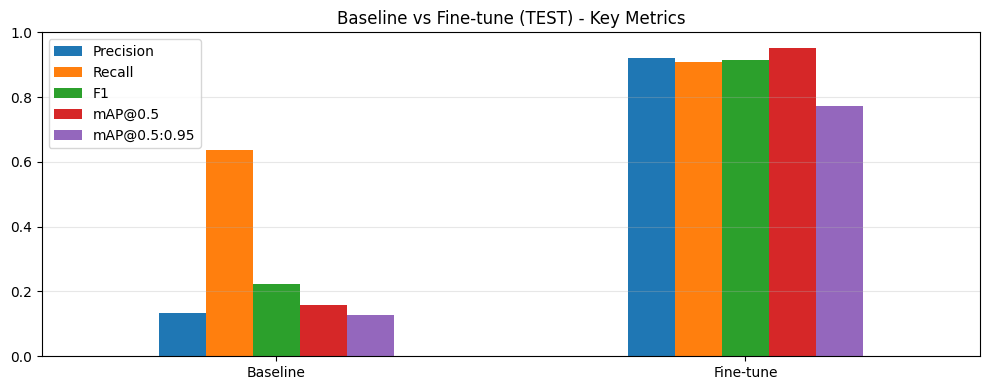

In [ ]:
# =========================
# Compare Baseline vs Fine-tune (table + plot)
# =========================
df = pd.DataFrame([BASELINE, FINETUNED], index=["Baseline", "Fine-tune"])
display(df)

ax = df.plot(kind="bar", figsize=(10, 4))
ax.set_title("Baseline vs Fine-tune (TEST) - Key Metrics")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# =========================
# Side-by-side predictions on TEST (Baseline vs Fine-tune) with short titles
# =========================
test_dir = ROBO_DIR / "test" / "images"
test_images = sorted([p for p in test_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
assert len(test_images) > 0, f"No test images found in: {test_dir}"

NUM_SHOW = min(30, len(test_images))
random.seed(SEED)
chosen = random.sample(test_images, k=NUM_SHOW)

# COCO animal class ids for pretrained YOLOv8 (COCO 80): bird..giraffe => 14..23
COCO_ANIMALS = list(range(14, 24))

def short_filename(p: Path, n: int = 35) -> str:
    s = p.stem
    return (s[:n] + "...") if len(s) > n else s

def predict_plot(model: YOLO, img_path: Path, title: str, classes=None):
    res = model.predict(
        source=str(img_path),
        imgsz=IMG_SIZE,
        conf=CONF_TH,
        classes=classes,
        verbose=False
    )[0]
    arr = res.plot()[..., ::-1]  # BGR -> RGB
    plt.imshow(arr)
    plt.title(title, fontsize=9)
    plt.axis("off")

cols = 2
rows = len(chosen)
plt.figure(figsize=(14, 3.8 * rows))

for i, img_path in enumerate(chosen):
    name = short_filename(img_path)

    plt.subplot(rows, cols, 2*i + 1)
    predict_plot(
        baseline_model,
        img_path,
        f"Baseline (COCO animals, conf>={CONF_TH}) | {name}",
        classes=COCO_ANIMALS
    )

    plt.subplot(rows, cols, 2*i + 2)
    predict_plot(
        ft_model,
        img_path,
        f"Fine-tune (single-class, conf>={CONF_TH}) | {name}",
        classes=None
    )

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from pathlib import Path


IMAGES_DIR = Path("/content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project/stage_2/images")
LABELS_DIR = Path("/content/drive/Othercomputers/ה-Mac שלי/Autonomous_Project/stage_2/annotations")

LABELS_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# כל התמונות
images = [p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in IMG_EXTS]

# צור רק עבור 100 הראשונות (אם יש פחות מ-100, ייצור עבור כולן)
images_100 = sorted(images)[:100]

created = 0שׂ
skipped = 0

for img_path in images_100:
    lbl_path = LABELS_DIR / f"{img_path.stem}.txt"
    if lbl_path.exists():
        skipped += 1
        continue
    lbl_path.write_text("")  # קובץ ריק = "אין אובייקטים"
    created += 1

print(f"Images checked: {len(images_100)}")
print(f"Empty label files created: {created}")
print(f"Skipped (already existed): {skipped}")


Images checked: 100
Empty label files created: 0
Skipped (already existed): 100


Loaded: /content/runs_yolo_compare/finetune/results.csv

Fit diagnosis: OK / UNCLEAR
Signals:
- No strong overfit pattern (mAP did not clearly drop after the peak, or losses do not diverge).

Best epoch (by val mAP): 29 (idx=28)


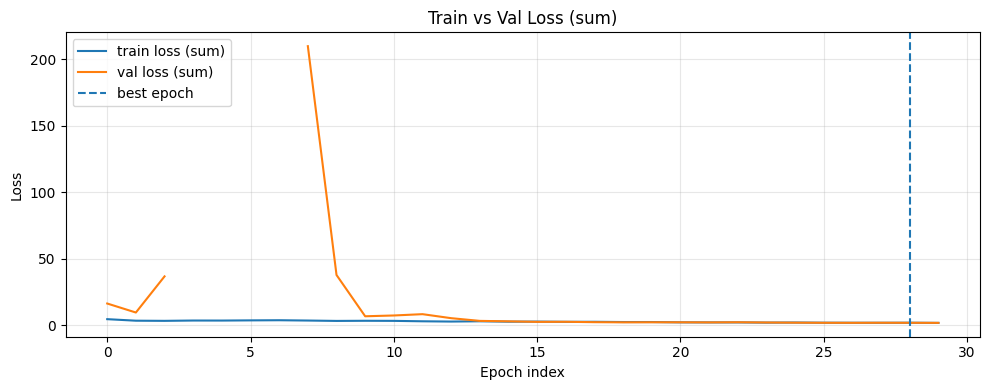

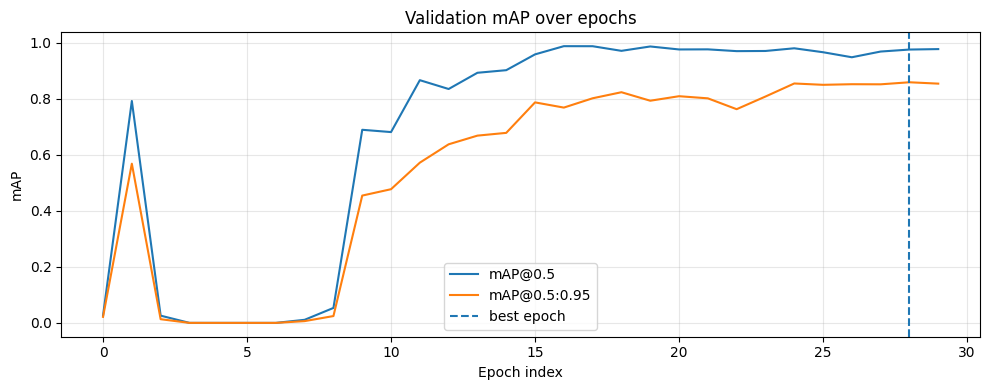

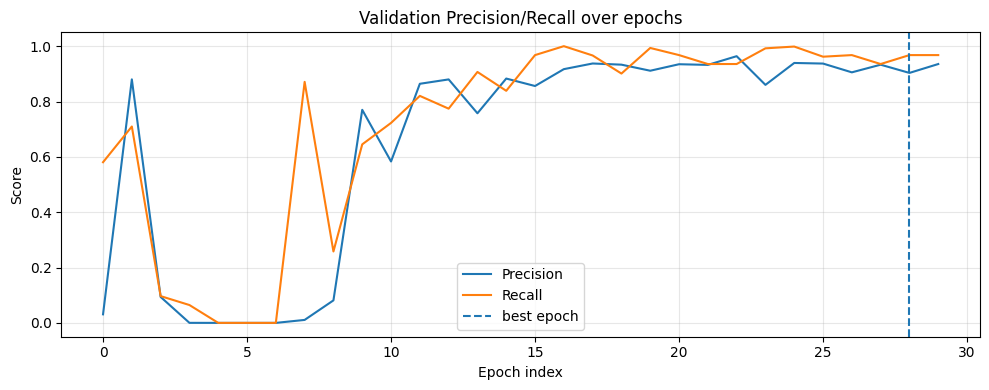

In [ ]:
# =========================================================
# BLOCK - Proper Overfit / Underfit Diagnosis (YOLO)
# Uses results.csv + visual + best-epoch logic
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def diagnose_fit(results_csv: Path, k=5,
                 map_drop_thr=0.02,
                 val_loss_rise_ratio=1.10,
                 train_loss_drop_ratio=0.95):
    """
    Heuristics (detection-friendly):
    - Overfit: val mAP peaked earlier and dropped in last k epochs,
              while train loss keeps improving and val loss worsens.
    - Underfit: val mAP stays low and does not improve much.
    - Otherwise: OK/UNCLEAR.
    """

    df = pd.read_csv(results_csv)

    # Build total losses
    train_box = _pick_col(df, ["train/box_loss"])
    train_cls = _pick_col(df, ["train/cls_loss"])
    train_dfl = _pick_col(df, ["train/dfl_loss"])

    val_box   = _pick_col(df, ["val/box_loss"])
    val_cls   = _pick_col(df, ["val/cls_loss"])
    val_dfl   = _pick_col(df, ["val/dfl_loss"])

    if not all([train_box, train_cls, train_dfl, val_box, val_cls, val_dfl]):
        raise ValueError("Missing expected loss columns in results.csv")

    train_loss = df[train_box] + df[train_cls] + df[train_dfl]
    val_loss   = df[val_box]   + df[val_cls]   + df[val_dfl]

    # Metrics
    col_map5095 = _pick_col(df, ["metrics/mAP50-95(B)", "metrics/mAP50-95"])
    col_map50   = _pick_col(df, ["metrics/mAP50(B)", "metrics/mAP50"])
    col_p       = _pick_col(df, ["metrics/precision(B)", "metrics/precision"])
    col_r       = _pick_col(df, ["metrics/recall(B)", "metrics/recall"])

    if col_map5095 is None and col_map50 is None:
        raise ValueError("Missing mAP columns in results.csv")

    val_map5095 = df[col_map5095] if col_map5095 else None
    val_map50   = df[col_map50] if col_map50 else None

    # Choose main score for best epoch
    main_score = val_map5095 if val_map5095 is not None else val_map50
    best_idx = int(main_score.idxmax())
    best_epoch = int(df.loc[best_idx, "epoch"]) if "epoch" in df.columns else best_idx

    # Last window stats
    k = min(k, len(df))
    last_idx = df.index[-k:]
    best_score = float(main_score.iloc[best_idx])
    last_score_mean = float(main_score.loc[last_idx].mean())

    # Compare losses around best vs last-k
    best_train_loss = float(train_loss.iloc[best_idx])
    best_val_loss   = float(val_loss.iloc[best_idx])
    last_train_loss_mean = float(train_loss.loc[last_idx].mean())
    last_val_loss_mean   = float(val_loss.loc[last_idx].mean())

    # Signals
    map_dropped = (last_score_mean < best_score - map_drop_thr)
    val_loss_worse = (last_val_loss_mean > best_val_loss * val_loss_rise_ratio)
    train_loss_better = (last_train_loss_mean < best_train_loss * train_loss_drop_ratio)

    # Underfit signals (simple + robust)
    score_range = float(main_score.max() - main_score.min())
    score_low = float(main_score.max()) < 0.30
    score_not_improving = score_range < 0.05

    if map_dropped and val_loss_worse and train_loss_better and (best_idx < len(df) - k):
        verdict = "OVERFIT"
        reasons = [
            f"val mAP peaked (best={best_score:.3f}) and dropped in last {k} epochs (mean={last_score_mean:.3f})",
            f"val loss worsened after best (best={best_val_loss:.3f}, last_mean={last_val_loss_mean:.3f})",
            f"train loss kept improving (best={best_train_loss:.3f}, last_mean={last_train_loss_mean:.3f})",
        ]
    elif score_low and score_not_improving:
        verdict = "UNDERFIT"
        reasons = [
            f"val mAP stayed low (max={float(main_score.max()):.3f})",
            f"val mAP barely improved (range={score_range:.3f})",
        ]
    else:
        verdict = "OK / UNCLEAR"
        reasons = [
            "No strong overfit pattern (mAP did not clearly drop after the peak, or losses do not diverge).",
        ]

    info = {
        "best_idx": best_idx,
        "best_epoch": best_epoch,
        "best_score": best_score,
        "last_score_mean": last_score_mean,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "last_train_loss_mean": last_train_loss_mean,
        "last_val_loss_mean": last_val_loss_mean,
    }
    return verdict, reasons, df, train_loss, val_loss, info, col_map50, col_map5095, col_p, col_r

# --------- locate results.csv from Ultralytics train output ----------
# If you have train_results object:
# save_dir = Path(train_results.save_dir)
# Otherwise set it manually:
# save_dir = Path("/content/runs_yolo_compare/finetune3")
save_dir = Path(train_results.save_dir)  # change if needed
results_csv = save_dir / "results.csv"
assert results_csv.exists(), f"Missing: {results_csv}"

verdict, reasons, df, train_loss, val_loss, info, col_map50, col_map5095, col_p, col_r = diagnose_fit(results_csv)

print(f"Loaded: {results_csv}")
print(f"\nFit diagnosis: {verdict}")
print("Signals:")
for r in reasons:
    print("-", r)
print(f"\nBest epoch (by val mAP): {info['best_epoch']} (idx={info['best_idx']})")

# ----------------- Visuals -----------------
best_idx = info["best_idx"]

# 1) Train vs Val total loss
plt.figure(figsize=(10,4))
plt.plot(train_loss.values, label="train loss (sum)")
plt.plot(val_loss.values, label="val loss (sum)")
plt.axvline(best_idx, linestyle="--", label="best epoch")
plt.title("Train vs Val Loss (sum)")
plt.xlabel("Epoch index")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Validation mAP curves
plt.figure(figsize=(10,4))
if col_map50:
    plt.plot(df[col_map50].values, label="mAP@0.5")
if col_map5095:
    plt.plot(df[col_map5095].values, label="mAP@0.5:0.95")
plt.axvline(best_idx, linestyle="--", label="best epoch")
plt.title("Validation mAP over epochs")
plt.xlabel("Epoch index")
plt.ylabel("mAP")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Precision / Recall (val)
if col_p and col_r:
    plt.figure(figsize=(10,4))
    plt.plot(df[col_p].values, label="Precision")
    plt.plot(df[col_r].values, label="Recall")
    plt.axvline(best_idx, linestyle="--", label="best epoch")
    plt.title("Validation Precision/Recall over epochs")
    plt.xlabel("Epoch index")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Recommendation
if verdict == "OVERFIT":
    print("\nRecommendation:")
    print("- Use early stopping at best epoch, or train fewer epochs.")
